In [313]:
import tensorflow as tf
import os
import pickle
import pandas as pd
import numpy as np

In [314]:
import tensorflow as tf
import os
import pickle
import pandas as pd
import numpy as np

def get_testing_data(directory,min_length,window_size):
    X = []
    y = []
    n = 60//window_size
    for f in os.listdir(directory):
        if f[0]=='.':
            continue
        data = pickle.load(open(directory+f,'rb'))
        if data.shape[0]//n<min_length:
            continue
        X.append(np.concatenate(list(data['data'])))
        y.extend([f]*data.shape[0])
    return np.concatenate(X),np.array(y)

window_size = 20
activity = 'std25'
n_user  = 315
min_length = 100
data_directory = './data/'+str(window_size)+'/'+activity+'/testing/'
model_directory = './models/'+str(window_size)+'/'+activity+'/'+str(n_user)+'/'
train_lengths = os.listdir(model_directory)
X,y = get_testing_data(data_directory,min_length,window_size)
save_directory = './predictions/'+str(window_size)+'/'+activity+'/'+str(n_user)+'/'
result_directory = './results/'
if not os.path.isdir(save_directory):
    os.makedirs(save_directory)

In [315]:
X.shape,y.shape

((285139, 500, 3), (285139,))

In [316]:
train_length = 300

In [317]:
model_files = [model_directory+str(train_length)+'/'+a for a in os.listdir(model_directory+str(train_length)) if a[-1]=='5']

In [318]:
model_name = model_files[0]

In [319]:
model = tf.keras.models.load_model(model_name)

In [320]:
model_new = tf.keras.models.Model(model.input,model.layers[-2].output)

In [321]:
y_pred = model_new.predict(X)

In [322]:
from copy import deepcopy
features = deepcopy(y_pred)

In [323]:
features.shape

(285139, 300)

In [324]:
from sklearn.decomposition import TruncatedSVD,PCA

In [325]:
features = PCA(n_components=100).fit_transform(features)

In [326]:
d = features.shape[1]
np.linalg.det(np.cov(features[:,:d].T))

2761495623391.1274

In [327]:
d = features.shape[1]
entropy = .5*np.log(np.linalg.det(np.cov(features[:,:d].T))) + (d/2)*(1+np.log(2*np.pi))
entropy

156.2172500911772

In [328]:
unique_users = np.unique(y)

In [329]:
len(unique_users)

315

In [331]:
user_df =pd.DataFrame({'user':np.unique(y)})
index_df = pd.DataFrame({'user':y,'index':np.arange(len(y))})
n_users = np.arange(1,10,1)
n_iter = 10

def get_average_entropy(n_user,n_iter):
    result = []
    for k in range(n_iter):
        temp_users = np.unique(user_df.sample(n_user,replace=False)['user'].values)
        index = index_df[index_df.user.isin(temp_users)]['index'].values
        temp_feature = features[index]
        d  = temp_feature.shape[1]
        entropy = .5*np.log(np.linalg.det(np.cov(temp_feature[:,:d].T))) + (d/2)*(1+np.log(2*np.pi))
        result.append(entropy)
    return np.array([n_user,np.mean(result)])
from joblib import Parallel,delayed
result = []
for i in range(1,295,20):
    entropies = Parallel(n_jobs=20,verbose=2)(delayed(get_average_entropy)(n_user,n_iter) for i,n_user in enumerate(range(i,i+20)))
    print(entropies)
    result.extend(entropies)
    pickle.dump(result,open('./data/entropies_'+str(activity)+'.p','wb'))

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:    3.7s remaining:   20.7s
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:    4.5s remaining:    1.9s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    4.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([  1.        , 108.71122131]), array([  2.        , 126.85411398]), array([  3.       , 126.2969499]), array([  4.        , 126.55416046]), array([  5.        , 133.05954141]), array([  6.        , 141.06057888]), array([  7.        , 137.93141951]), array([  8.        , 137.46233719]), array([  9.        , 142.66729196]), array([ 10.        , 138.30005812]), array([ 11.        , 140.95824047]), array([ 12.        , 142.99617249]), array([ 13.        , 142.10520811]), array([ 14.        , 145.01263868]), array([ 15.        , 144.69290752]), array([ 16.        , 146.96850878]), array([ 17.        , 146.05116136]), array([ 18.        , 146.55839272]), array([ 19.        , 147.93088456]), array([ 20.        , 146.40939605])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:    0.7s remaining:    3.7s
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:    1.4s remaining:    0.6s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    1.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([ 21.        , 146.39533102]), array([ 22.        , 148.31132619]), array([ 23.        , 145.85310104]), array([ 24.        , 148.71228768]), array([ 25.        , 146.62995708]), array([ 26.        , 146.96583909]), array([ 27.       , 148.8630337]), array([ 28.        , 146.89013191]), array([ 29.        , 145.95285318]), array([ 30.        , 149.44470994]), array([ 31.        , 149.49285617]), array([ 32.        , 148.41078982]), array([ 33.        , 149.45587508]), array([ 34.        , 152.04696465]), array([ 35.      , 150.055138]), array([ 36.        , 149.44457903]), array([ 37.        , 148.08378654]), array([ 38.        , 149.47440059]), array([ 39.        , 151.37207849]), array([ 40.        , 150.17703626])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:    0.7s remaining:    4.2s
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    2.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([ 41.        , 149.33130408]), array([ 42.        , 150.48208963]), array([ 43.        , 150.67246568]), array([ 44.        , 150.99872422]), array([ 45.        , 150.16714954]), array([ 46.        , 151.14424114]), array([ 47.        , 151.43754343]), array([ 48.        , 152.45999451]), array([ 49.        , 150.94445513]), array([ 50.        , 152.09622507]), array([ 51.        , 150.76897575]), array([ 52.        , 151.26935468]), array([ 53.        , 151.72655653]), array([ 54.        , 153.02158189]), array([ 55.        , 153.17490576]), array([ 56.        , 152.21446249]), array([ 57.        , 150.50181315]), array([ 58.        , 152.68519456]), array([ 59.        , 151.92667467]), array([ 60.        , 150.63100836])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:    0.9s remaining:    5.1s
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:    1.9s remaining:    0.8s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    2.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([ 61.        , 152.48455633]), array([ 62.        , 152.54125295]), array([ 63.        , 151.66380594]), array([ 64.       , 152.4371663]), array([ 65.        , 153.46939293]), array([ 66.        , 151.99828257]), array([ 67.        , 151.35257296]), array([ 68.       , 152.2839335]), array([ 69.        , 152.16922871]), array([ 70.        , 152.94472536]), array([ 71.        , 153.13719296]), array([ 72.        , 152.86964635]), array([ 73.        , 152.67853264]), array([ 74.        , 153.25185005]), array([ 75.        , 153.91843883]), array([ 76.        , 152.71580117]), array([ 77.        , 152.48186184]), array([ 78.        , 153.78468438]), array([ 79.        , 153.28347037]), array([ 80.       , 153.5527052])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:    1.3s remaining:    7.2s
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:    2.3s remaining:    1.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    2.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([ 81.        , 153.09687426]), array([ 82.        , 152.80678508]), array([ 83.        , 153.32633117]), array([ 84.      , 151.945376]), array([ 85.        , 153.81526502]), array([ 86.        , 153.85654555]), array([ 87.        , 152.70394872]), array([ 88.        , 153.25791372]), array([ 89.        , 153.65507836]), array([ 90.       , 152.3165001]), array([ 91.        , 153.81533631]), array([ 92.        , 153.93801709]), array([ 93.        , 153.20389004]), array([ 94.        , 153.71592162]), array([ 95.        , 154.68160512]), array([ 96.        , 153.50284742]), array([ 97.        , 153.95471051]), array([ 98.        , 154.04143725]), array([ 99.       , 154.7334561]), array([100.        , 153.41012878])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:    1.4s remaining:    8.0s
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:    2.7s remaining:    1.2s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    3.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([101.        , 154.69623717]), array([102.        , 153.76317349]), array([103.        , 153.93664173]), array([104.     , 153.40764]), array([105.        , 154.05178686]), array([106.        , 154.29034934]), array([107.        , 154.41809698]), array([108.        , 154.12529046]), array([109.      , 153.317563]), array([110.        , 153.97483846]), array([111.        , 153.92099466]), array([112.        , 154.16417953]), array([113.        , 153.33426487]), array([114.        , 153.46499282]), array([115.        , 154.05341274]), array([116.        , 154.18326924]), array([117.        , 154.23987206]), array([118.        , 153.70795158]), array([119.        , 153.95714325]), array([120.       , 154.4621931])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:    1.7s remaining:    9.4s
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:    3.1s remaining:    1.3s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    3.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([121.        , 154.11800841]), array([122.        , 154.26202665]), array([123.        , 154.26274022]), array([124.        , 154.02539365]), array([125.        , 154.44485986]), array([126.        , 154.60242281]), array([127.        , 154.00232167]), array([128.        , 154.83531216]), array([129.        , 154.74777481]), array([130.        , 153.71165928]), array([131.        , 154.99658267]), array([132.        , 154.52978256]), array([133.        , 154.65537751]), array([134.        , 153.68226622]), array([135.        , 154.93138082]), array([136.        , 155.26420448]), array([137.        , 154.05924027]), array([138.        , 154.13345135]), array([139.       , 154.4211013]), array([140.       , 154.7552439])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:    1.8s remaining:   10.2s
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:    3.5s remaining:    1.5s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    4.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([141.        , 155.01149387]), array([142.       , 154.0372831]), array([143.        , 154.07736471]), array([144.        , 154.86040014]), array([145.        , 154.14120516]), array([146.        , 155.16707199]), array([147.        , 154.82810748]), array([148.        , 155.20562977]), array([149.        , 154.37141549]), array([150.        , 154.59817955]), array([151.        , 154.32289685]), array([152.        , 154.64665696]), array([153.        , 155.22383862]), array([154.        , 154.76632582]), array([155.       , 155.0382891]), array([156.        , 154.95962261]), array([157.       , 155.3748407]), array([158.        , 154.98120489]), array([159.        , 154.91998078]), array([160.        , 155.08147034])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:    2.4s remaining:   13.4s
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:    3.9s remaining:    1.7s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    4.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([161.        , 154.49181775]), array([162.       , 154.4883303]), array([163.        , 155.34740501]), array([164.        , 155.41954977]), array([165.        , 155.12713367]), array([166.        , 154.96322954]), array([167.        , 155.11687245]), array([168.        , 154.32265994]), array([169.        , 155.17038891]), array([170.        , 154.59329233]), array([171.        , 155.50065837]), array([172.        , 155.19364321]), array([173.        , 155.43415898]), array([174.        , 155.32607734]), array([175.        , 154.59248098]), array([176.        , 154.94223797]), array([177.        , 155.34334318]), array([178.        , 155.02491852]), array([179.      , 155.651671]), array([180.        , 155.49475873])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:    2.6s remaining:   14.6s
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:    4.1s remaining:    1.8s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    4.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([181.        , 155.18822507]), array([182.        , 154.89148406]), array([183.        , 155.28949037]), array([184.        , 155.52042043]), array([185.        , 155.35361255]), array([186.        , 155.30020002]), array([187.       , 155.3819625]), array([188.        , 155.67760085]), array([189.        , 154.85272942]), array([190.       , 155.2118627]), array([191.        , 155.63415287]), array([192.        , 155.51916489]), array([193.        , 155.53977855]), array([194.        , 155.44839618]), array([195.        , 155.14010249]), array([196.        , 155.36257703]), array([197.        , 154.97496472]), array([198.        , 155.19374155]), array([199.        , 155.76554812]), array([200.        , 155.22870759])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:    2.8s remaining:   16.0s
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:    4.8s remaining:    2.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    5.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([201.        , 155.23629648]), array([202.        , 155.69482637]), array([203.        , 155.48074434]), array([204.        , 155.61477826]), array([205.        , 155.42921525]), array([206.        , 155.48383255]), array([207.        , 155.33303062]), array([208.        , 155.49155395]), array([209.        , 155.87224382]), array([210.        , 155.68244675]), array([211.        , 156.14839762]), array([212.        , 155.75787589]), array([213.        , 155.79708734]), array([214.        , 155.52304123]), array([215.        , 155.84709481]), array([216.        , 155.58715835]), array([217.        , 155.42602526]), array([218.        , 155.53579264]), array([219.        , 155.41177513]), array([220.        , 155.72877757])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:    3.4s remaining:   19.5s
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:    5.2s remaining:    2.2s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    5.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([221.        , 155.19040787]), array([222.       , 156.1044204]), array([223.        , 155.58664396]), array([224.        , 155.64804504]), array([225.        , 155.77136814]), array([226.        , 155.48096279]), array([227.        , 155.45326979]), array([228.        , 155.60493231]), array([229.        , 155.64421052]), array([230.        , 155.92346149]), array([231.      , 156.091067]), array([232.        , 155.64397159]), array([233.        , 155.84478252]), array([234.        , 155.69532626]), array([235.        , 155.62518106]), array([236.        , 155.67128326]), array([237.        , 155.65199866]), array([238.        , 155.89803591]), array([239.        , 155.77972426]), array([240.        , 155.62312931])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:    3.7s remaining:   21.2s
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:    5.6s remaining:    2.4s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    6.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([241.        , 155.45500116]), array([242.        , 156.06310583]), array([243.        , 155.78932564]), array([244.        , 155.88351694]), array([245.        , 155.49006989]), array([246.        , 155.60943193]), array([247.        , 155.94475383]), array([248.        , 155.70166196]), array([249.        , 155.64746918]), array([250.       , 155.9807244]), array([251.        , 155.68996867]), array([252.        , 155.81177426]), array([253.        , 155.71852109]), array([254.        , 155.97143033]), array([255.        , 155.77440453]), array([256.        , 155.79444363]), array([257.        , 156.22342023]), array([258.      , 155.961063]), array([259.        , 155.92598944]), array([260.        , 156.03272873])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:    3.8s remaining:   21.8s
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:    6.0s remaining:    2.6s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    6.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([261.        , 156.06427397]), array([262.        , 155.71863193]), array([263.        , 155.60781861]), array([264.        , 155.66098323]), array([265.        , 156.02897958]), array([266.        , 155.85607603]), array([267.        , 156.18747655]), array([268.        , 155.72295815]), array([269.        , 155.76868806]), array([270.        , 156.41206071]), array([271.        , 155.98358258]), array([272.        , 155.74869057]), array([273.        , 156.10373948]), array([274.        , 155.99542357]), array([275.        , 155.97098795]), array([276.        , 155.95390003]), array([277.        , 156.05585206]), array([278.        , 156.01603276]), array([279.        , 156.15963473]), array([280.        , 156.04125239])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:    4.9s remaining:   27.5s
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:    6.6s remaining:    2.8s


[array([281.        , 155.89317709]), array([282.        , 156.22224552]), array([283.      , 156.193974]), array([284.        , 156.08378502]), array([285.       , 156.1173505]), array([286.        , 156.24167611]), array([287.       , 156.1689274]), array([288.       , 156.1597598]), array([289.        , 156.31736954]), array([290.        , 156.15827786]), array([291.       , 156.0907058]), array([292.        , 155.98162046]), array([293.        , 156.07852106]), array([294.        , 156.09537606]), array([295.        , 156.05779703]), array([296.        , 156.07932781]), array([297.        , 156.07525136]), array([298.        , 156.16479368]), array([299.        , 156.10933034]), array([300.        , 156.04322294])]


[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    7.0s finished


In [210]:
activity = 'sports'
result = pickle.load(open('./data/entropies_'+str(activity)+'.p','rb'))

In [334]:
activities = ['sports','walking','std','std15','std30','std25','stairs']

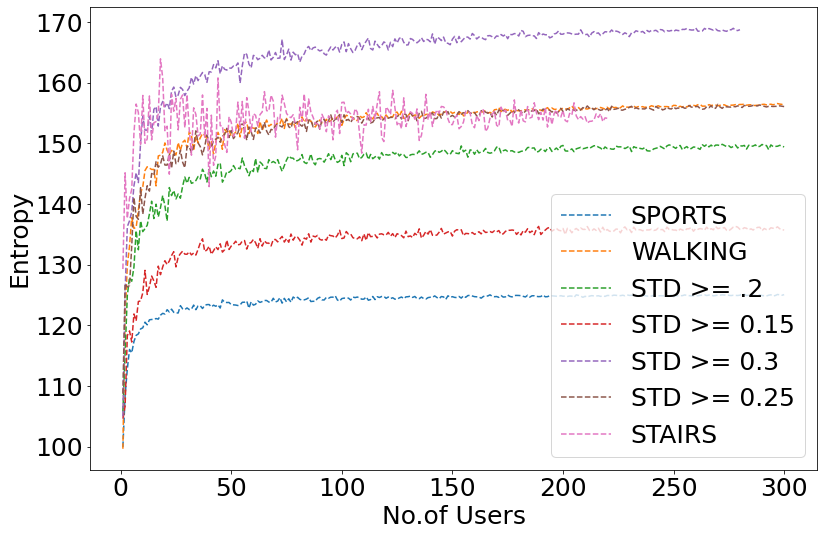

In [335]:
plt.rcParams.update({'font.size':25})
plt.figure(figsize=(12,8))
for i,activity in enumerate(activities):
    result = pickle.load(open('./data/entropies_'+str(activity)+'.p','rb'))
    result = np.array(result)
    result = result[result[:,0]<=300]
    if activity[:3]!='std':
        plt.plot(result[:,0],result[:,1],'--',label=activity.upper())
    elif activity=='std':
        plt.plot(result[:,0],result[:,1],'--',label=activity.upper()+' >= ''.2')
    else:
        plt.plot(result[:,0],result[:,1],'--',label=activity[:3].upper()+' >= '+str(int(activity[3:])/100))
plt.ylabel('Entropy')
plt.xlabel('No.of Users')
plt.legend()
plt.tight_layout()
plt.savefig('./images/entropy.png')
plt.show()

In [191]:
result = np.array(result)

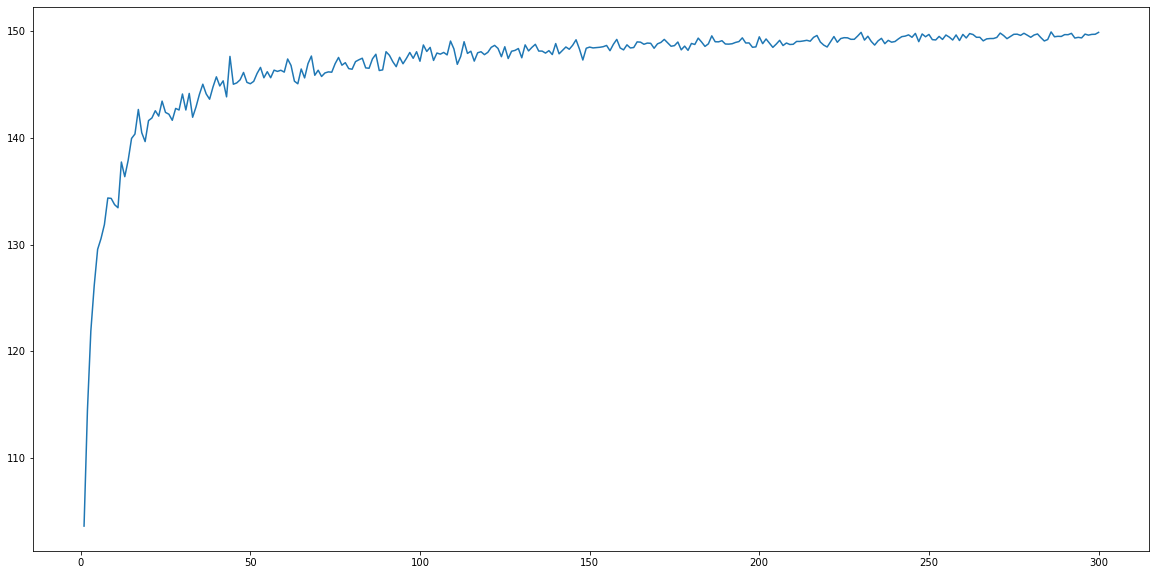

In [192]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(result[:,0],result[:,1])
plt.show()

In [196]:
activities = ['walking','sports','std']

In [197]:
for activity in activities[::-1]:
    result = np.array(pickle.load(open('./data/entropies_'+str(activity)+'.p')))
    print(result)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte